In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import warnings

sns.set()
rcParams['figure.figsize'] = (20,10)
pd.options.display.max_columns = None
warnings.filterwarnings('ignore')
from pprint import pprint
import json

from transformers import AutoTokenizer, AutoModel, AutoConfig, pipeline
from datasets import load_dataset, Dataset, concatenate_datasets
import swifter

In [3]:
tokenizer = AutoTokenizer.from_pretrained("bigscience/bloom-7b1")

### CNN_DAILY

In [ ]:
cnn = Dataset.from_json('../../data/translated/cnn_dailymail_30k_samples_len_100_1200_words_translated.json')

In [ ]:
input_template="Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Tóm tắt ngắn gọn đoạn văn bản sau đây:\n{article_translated}\n[|AI|] "
def mapper(x):
    return {
        'input': input_template.format(article_translated=x['article_translated']),
        'output': 'Đoạn văn bản đã được tóm tắt:\n' + x['highlights_translated'] + '\n[|Con người|]'
    }

temp_cnn = cnn.shuffle().select(range(15000)).map(mapper,batched=False, remove_columns=['article_translated','highlights_translated'])

In [ ]:
print(temp_cnn[1]['input'] + temp_cnn[1]['output'])

In [ ]:
length = temp_cnn.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input'] + x['output']))})
length.to_pandas().hist(bins=100)

In [ ]:
temp_cnn[0]

In [ ]:
temp_cnn.to_json('../../data/training_3_8/cnn_15k_samples.jsonl', orient='records', lines=True)

### DIALOG SUMMARY

In [ ]:
dialog = Dataset.from_json('../../data/translated/dialogsum_10k_samples_len_50_words_translated.json')

In [ ]:
dialog

In [ ]:
input_template="Tóm tắt ngắn gọn đoạn hội thoại sau đây:\n{dialogue_translated}\nĐoạn hội thoại đã được tóm tắt:\n"
def mapper(x):
    return {
        'input': input_template.format(dialogue_translated=x['dialogue_translated']),
        'output': x['summary_translated']
    }

temp_dialog = dialog.shuffle().select(range(10000)).map(mapper,batched=False, remove_columns=['dialogue_translated','summary_translated'])

In [ ]:
print(temp_dialog[1]['input'] + temp_dialog[1]['output'])

In [ ]:
temp_dialog[0]

In [ ]:
temp_dialog.to_json('../../data/training_3_8/dialogsum_10k_samples.jsonl', orient='records', lines=True)

### FAQS

In [818]:
faqs = Dataset.from_json('../../../data/training_31_7/faq_chat_10k.jsonl')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0)


In [819]:
print(faqs.shuffle()[0]['input'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên điều luật được cung cấp. Nếu không đủ thông tin để trả lời thì trả lời: Tôi không biết.
Câu hỏi: Ông Phan bị công an bắt quả tang khi đang trên đường vận chuyển ma túy từ Lào Cai về Hà Nội. Sau khi khám xét, công an thu được tổng số lượng heroin là 50 gam. Trong trường hợp này, ông Phan sẽ bị xử lý như thế nào?
Điều luật liên quan: Điều 194. Tội tàng trữ, vận chuyển, mua bán trái phép hoặc chiếm đoạt chất ma túy 1. Người nào tàng trữ, vận chuyển, mua bán trái phép hoặc chiếm đoạt chất ma tuý, thì bị phạt tù từ hai năm đến bảy năm. 2. Phạm tội thuộc một trong các trường hợp sau đây, thì bị phạt tù từ bảy năm đến mười lăm năm: a) Có tổ chức; b) Phạm tội nhiều lần; c) Lợi dụng chức vụ, quyền hạn; d) Lợi dụng danh nghĩa cơ quan, tổ chức; đ) Vận chuyển, mua bán qua biên giới; e) Sử dụng trẻ em vào việc phạm tội hoặc bán ma tuý cho trẻ em;

In [820]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
text2 = ' Nếu không đủ thông tin để trả lời thì trả lời: Tôi không biết.'
text3 = 'Điều luật liên quan: '
text4 = ' Chỉ được trả lời dựa trên điều luật được cung cấp.'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text).replace(text2,'').replace(text3, 'Điều luật liên quan:\n').replace(text4, '') + '\n[|Con người|]',
    }

def mapper2(x):
    ai_index = x['output'].find('[|AI|]')
    return {
        'input': x['input'] + x['output'][:ai_index + 7],
        'output': x['output'][ai_index + 7:],
    }

temp_faqs = faqs.map(mapper, batched=False).map(mapper2, batched=False)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0/cache-761db58758c19ad3.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-e90f1f489bc5a6e2/0.0.0/cache-a81d967f499143fb.arrow


In [821]:
temp_faqs_df = temp_faqs.to_pandas()
temp_faqs_df = temp_faqs_df.drop_duplicates(subset=['output']).reset_index(drop=True)
temp_faqs_df['length_input'] = temp_faqs_df['input'].apply(lambda x: len(tokenizer.tokenize(x)))
temp_faqs_df['length_output'] = temp_faqs_df['output'].apply(lambda x: len(tokenizer.tokenize(x)))

In [823]:
temp_faqs_df

,input,output,length_input,length_output
0,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định tại Điều 57 Bộ luật Hình sự 2015...,257,209
1,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Giữa bạn và người bạn của mình đã giao kết hợp...,364,335
2,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Căn cứ theo quy định tại Điều 51 Luật thi hành...,642,317
3,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,1. Chơi tài xỉu có phải là đánh bạc? Tài xỉu l...,797,912
4,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo Điều 472 Bộ Luật Dân Sự 2015 thì hợp đồng...,146,192
...,...,...,...,...
2617,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Thời gian làm thêm giờ (hay còn gọi là giờ tăn...,513,514
2618,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định Khoản 4 tại Điều 250 Bộ luật hìn...,1399,224
2619,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Căn cứ khoản 3 Điều 111 Bộ luật Lao động 2019 ...,214,211
2620,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,1. Đối tượng áp dụng Tái hòa nhập cộng đồng th...,723,439


In [822]:
temp = temp_faqs.shuffle()[0]
pprint(temp['input'])
pprint(temp['output'])


('Cuộc trò chuyện giữa con người và trợ lý AI.\n'
 '[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan '
 'dưới đây.\n'
 'Câu hỏi: Bố tôi mua một khu đất của ông A từ năm 2005 (có đầy đủ giấy tờ mua '
 'bán và đã trả đủ tiền). Đến nay là 10 năm, cả bố tôi và ông A đều đã qua '
 'đời. Bìa đỏ hiện vẫn mang tên ông A. Tôi muốn hỏi về thủ tục làm giấy tờ '
 'chuyển quyền sử dụng đất? Ngoài ra, nếu bây giờ các con của ông A gây khó '
 'khăn do không được làm chứng việc mua bán đó thì phải làm thế nào?\n'
 'Điều luật liên quan:\n'
 'Điều 109. Chiếm hữu, sử dụng, định đoạt tài sản chung của hộ gia đình 1. Các '
 'thành viên của hộ gia đình chiếm hữu và sử dụng tài sản chung của hộ theo '
 'phương thức thoả thuận. 2. Việc định đoạt tài sản là tư liệu sản xuất, tài '
 'sản chung có giá trị lớn của hộ gia đình phải được các thành viên từ đủ mười '
 'lăm tuổi trở lên đồng ý; đối với các loại tài sản chung khác phải được đa số '
 'thành viên từ đủ mười lăm tuổi trở lên đồng 

<AxesSubplot:>

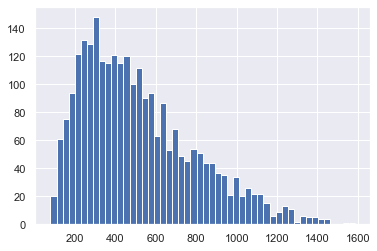

In [164]:
temp_faqs_df['length_input'].hist(bins=50)

<AxesSubplot:>

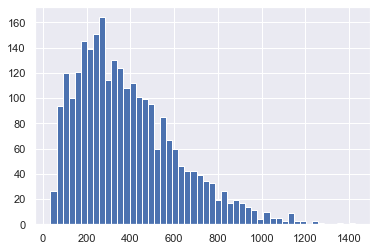

In [165]:
temp_faqs_df['length_output'].hist(bins=50)

In [189]:
temp_1 = temp_faqs_df[(temp_faqs_df['length_output'] <= 0.7 * temp_faqs_df['length_input']) & (temp_faqs_df['length_output'] <= 300)].reset_index(drop=True)
temp_1

,input,output,length_input,length_output
0,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo Điều 429 Bộ Luật Dân sự 2015 quy định về ...,113,69
1,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,"Hàng hóa luân chuyển trong quá trình sản xuất,...",825,274
2,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Ngày kháng cáo được xác định quy định tại khoả...,338,198
3,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định tại khoản 3 Điều 51 Luật Hôn nhâ...,229,95
4,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định của Bộ luật Dân sự năm 2005 và Đ...,191,128
...,...,...,...,...
744,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo Điều 603 Bộ luật Dân sự 2015 việc bồi thư...,296,101
745,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định tại Điều 52 Luật Đất đai 2013 th...,136,87
746,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định tại Điều 41 Nghị định số 22/2017...,588,259
747,Cuộc trò chuyện giữa con người và trợ lý AI.\n...,Theo quy định Khoản 4 tại Điều 250 Bộ luật hìn...,1399,224


<AxesSubplot:>

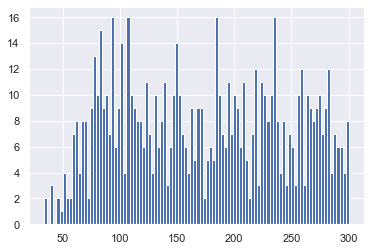

In [190]:
temp_1['length_output'].hist(bins=100)

In [191]:
temp_faqs = Dataset.from_pandas(temp_1)
temp = temp_faqs.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây.
Câu hỏi: Buôn bán vaccine covid 19 giả bị áp dụng những hình phạt bổ sung nào?
Điều luật liên quan:
Điều 9. Hành vi buôn bán hàng giả về giá trị sử dụng, công dụng 1. Đối với hành vi buôn bán hàng giả về giá trị sử dụng, công dụng quy định tại điểm a, b, c và d khoản 7 Điều 3 của Nghị định này, mức phạt tiền như sau: a) Phạt tiền từ 1.000.000 đồng đến 3.000.000 đồng trong trường hợp hàng giả tương đương với số lượng của hàng thật có trị giá dưới 3.000.000 đồng hoặc thu lợi bất hợp pháp dưới 5.000.000 đồng; b) Phạt tiền từ 3.000.000 đồng đến 5.000.000 đồng trong trường hợp hàng giả tương đương với số lượng của hàng thật có trị giá từ 3.000.000 đồng đến dưới 5.000.000 đồng hoặc thu lợi bất hợp pháp từ 5.000.000 đồng đến dưới 10.000.000 đồng; c) Phạt tiền từ 5.000.000 đồng đến 10.000.000 đồng trong trường hợp hàng giả tương đương với số lượng của hàng thật có tr

In [192]:
pprint(temp['input'])
pprint(temp['output'])

('Cuộc trò chuyện giữa con người và trợ lý AI.\n'
 '[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan '
 'dưới đây.\n'
 'Câu hỏi: Buôn bán vaccine covid 19 giả bị áp dụng những hình phạt bổ sung '
 'nào?\n'
 'Điều luật liên quan:\n'
 'Điều 9. Hành vi buôn bán hàng giả về giá trị sử dụng, công dụng 1. Đối với '
 'hành vi buôn bán hàng giả về giá trị sử dụng, công dụng quy định tại điểm a, '
 'b, c và d khoản 7 Điều 3 của Nghị định này, mức phạt tiền như sau: a) Phạt '
 'tiền từ 1.000.000 đồng đến 3.000.000 đồng trong trường hợp hàng giả tương '
 'đương với số lượng của hàng thật có trị giá dưới 3.000.000 đồng hoặc thu lợi '
 'bất hợp pháp dưới 5.000.000 đồng; b) Phạt tiền từ 3.000.000 đồng đến '
 '5.000.000 đồng trong trường hợp hàng giả tương đương với số lượng của hàng '
 'thật có trị giá từ 3.000.000 đồng đến dưới 5.000.000 đồng hoặc thu lợi bất '
 'hợp pháp từ 5.000.000 đồng đến dưới 10.000.000 đồng; c) Phạt tiền từ '
 '5.000.000 đồng đến 10.000.000 đồng tron

In [194]:
temp_faqs.remove_columns(['length_input', 'length_output'])
temp_faqs.to_json('../../../data/training_14_8/faqs.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

4434206

### SHARE_GPT

In [ ]:
share = pd.read_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/original/share_gpt_no_code_conversations_40k.json', orient='records', lines=True)
share.columns = ['input']
share.dropna(inplace=True)
share.reset_index(drop=True, inplace=True)
share = Dataset.from_pandas(share)

In [ ]:
share = share.filter(lambda x: len(tokenizer.tokenize(x["input"])) < 2000)

In [ ]:
share.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['input']))}).to_pandas().hist(bins=100)

In [ ]:
# text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
text = 'The conversation between human and AI assistant.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['input'].removeprefix(text) + '\n[|Con người|]'
    }
share = share.map(mapper, batched=False)

In [ ]:
share

In [ ]:
share[0]

In [ ]:
share

In [ ]:
share.to_json('../../data/training_english/share_gpt_38k.jsonl', orient='records', lines=True)

### QUORA

In [ ]:
quora = Dataset.from_json('../../../data/translated/quora_chat_data_translated.json')

In [ ]:
print(quora.shuffle()[0]['prompt'])

In [ ]:
quora.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['prompt']))}).to_pandas().hist(bins=100)

In [ ]:
temp_quora = quora.shuffle().select(range(20000))
temp_quora

In [ ]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['prompt'].removeprefix(text) + '\n[|Con người|]',
    }

temp_quora = temp_quora.map(mapper, batched=False, remove_columns=['prompt'])

In [ ]:
temp_quora.to_json('../../data/training_3_8/quora_20k_samples.jsonl', orient='records', lines=True)

### OASST

In [ ]:
oasst = Dataset.from_json('/Users/phamhoang1408/Desktop/Phase 2 Viettel/main_repo/data/translated/oasst_translated.json')
oasst = oasst.filter(lambda x: not ('```' in x['text'] or 'trăn' in x['text'] or "'''" in x['text']))
oasst

In [ ]:
temp_oasst2 = oasst.filter(lambda x: len(tokenizer.tokenize(x['text'])) > 100)

In [ ]:
temp_oasst2

In [ ]:
text = 'Cuộc trò chuyện giữa con người và trợ lý AI.\n'
def mapper(x):
    return {
        'input': text,
        'output': x['text'].removeprefix(text)
    }

temp_oasst = temp_oasst2.map(mapper, batched=False, remove_columns=['text'])

In [ ]:
temp = temp_oasst.shuffle()[0]
print(temp['input'] + temp['output'])

In [ ]:
temp_oasst.to_json('../../../data/training_14_8/oasst_19k_samples.jsonl', orient='records', lines=True)

In [ ]:
oasst.shuffle().select(range(1000)).map(lambda x: {'len':len(tokenizer.tokenize(x['text']))}).to_pandas().hist(bins=100)

In [ ]:
print(temp_oasst.shuffle()[0])

In [ ]:
temp_oasst.to_json('../../data/training_3_8/oasst_20k_samples.jsonl', orient='records', lines=True)

### ALPACA CHAT

In [15]:
alpaca = Dataset.from_json('../../../data/translated/alpaca_chat_cleaned_51k_translated.json')
temp_df = alpaca.to_pandas()
temp_length = temp_df.apply(lambda x: len(tokenizer.tokenize(x['prompt'])), axis=1)

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e8795aa44813c1e9/0.0.0)


In [16]:
alpaca_temp = Dataset.from_pandas(temp_df[temp_length>=150].reset_index(drop=True))
alpaca_temp

Dataset({
    features: ['prompt'],
    num_rows: 14747
})

In [123]:
print(alpaca_temp.shuffle()[0]['prompt'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Xây dựng một sân bán hàng để khuyến khích mọi người mua một máy theo dõi thể dục.
[|AI|] Trình theo dõi thể dục của chúng tôi là cách hoàn hảo để giúp bạn theo dõi các mục tiêu thể dục của bạn. Nó theo dõi các bước, nhịp tim và calo của bạn được đốt cháy và cho phép bạn theo dõi tiến trình của mình theo thời gian. Với màn hình dễ đọc, bạn có thể nhanh chóng kiểm tra tiến trình của mình trong suốt cả ngày. Thêm vào đó, thiết kế kiểu dáng đẹp và thời lượng pin dài có nghĩa là bạn có thể mặc nó ở bất cứ đâu và mọi lúc. Tận dụng tối đa tập luyện của bạn và đảm bảo bạn theo dõi với trình theo dõi thể dục của chúng tôi!
[|Con người|]


In [ ]:
def mapper(x):
    ai_index = x['prompt'].find('[|AI|]')
    return {
        'input': x['prompt'][:ai_index+7],
        'output': x['prompt'][ai_index + 7:]
    }
temp_alpaca = alpaca_temp.map(mapper, batched=False, remove_columns=alpaca.column_names)

In [ ]:
temp_alpaca.shuffle()[0]

In [ ]:
temp_alpaca.to_json('../../../data/training_14_8/alpaca_chat_26k_samples.jsonl', orient='records', lines=True)

### GPT4 INSTRUCT

In [83]:
gpt4 = Dataset.from_json('../../../data/translated/gpt4_instruct_similarity_0_9_translated.jsonl')
gpt4

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-53a1d8892b43af61/0.0.0)


Dataset({
    features: ['instruction_translated', 'input_translated', 'response_translated'],
    num_rows: 17873
})

In [84]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n{input_translated}\n[|AI|] "
template2 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n[|AI|] "

def mapper(x):
    if x['input_translated'] != '' and x['input_translated'] is not None:
        template = template1.format(
            instruction_translated=x['instruction_translated'], 
            input_translated=x['input_translated']
        )
    else:
        template = template2.format(instruction_translated=x['instruction_translated'])
    return {
        'input': template,
        'output': x['response_translated'] + '\n[|Con người|]'
    }

temp_gpt4 = gpt4.map(mapper,batched=False, remove_columns=gpt4.column_names)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-53a1d8892b43af61/0.0.0/cache-27c0a5f7bf41c516.arrow


In [85]:
temp_gpt4

Dataset({
    features: ['input', 'output'],
    num_rows: 17873
})

In [98]:
a = temp_gpt4.shuffle()[0]
print(a['input']+a['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Giúp cải thiện câu sau trong một bài báo khoa học: 'Điều đáng chú ý là các nghiên cứu khác nhau đã chỉ ra rằng nước đóng vai trò chính trong quá trình tổng hợp các hợp chất hữu cơ quan trọng.'
[|AI|] Trong khuôn khổ một bài báo khoa học, có thể cải nghĩa câu như sau: 'Nhiều nghiên cứu đã chứng minh rằng nước đóng vai trò cốt yếu trong quá trình tổng hợp các chất thiết yếu. hợp chất hữu cơ.' Câu văn được sửa đổi ngắn gọn hơn, tránh dư thừa và sử dụng ngôn ngữ chính xác và học thuật hơn.
[|Con người|]


In [11]:
temp_gpt4.to_json('../../data/training_3_8/gpt4_instruct.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

26685705

### DOLLY WITH CONTEXT

In [57]:
dolly = Dataset.from_json('../../../data/translated/dolly_with_context_translated.jsonl')
dolly = dolly.remove_columns(['instruction', 'context', 'response', 'category_translated'])

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-e7046f43243de008/0.0.0)


In [58]:
dolly.shuffle()[0]

{'instruction_translated': 'Edward Gramlich là ai',
 'context_translated': 'Edward M. Gramlich (18 tháng 6 năm 1939 – 5 tháng 9 năm 2007) là một nhà kinh tế học người Mỹ, từng là thành viên của Hội đồng Thống đốc Cục Dự trữ Liên bang từ năm 1997 đến năm 2005. Gramlich cũng là quyền giám đốc Văn phòng Ngân sách Quốc hội.\n\nGramlich tốt nghiệp Williams College năm 1961 và nhận bằng thạc sĩ năm 1962 và bằng tiến sĩ. về kinh tế năm 1965 từ Đại học Yale. Ông gia nhập Cục Dự trữ Liên bang với tư cách là nhà nghiên cứu kinh tế từ năm 1965 đến năm 1970, và là thành viên cao cấp tại Viện Brookings từ năm 1973 đến năm 1976. Sau đó, ông dạy kinh tế và chính sách công tại Đại học Michigan từ năm 1976 đến năm 1997, bao gồm cả nhiệm kỳ trưởng khoa. của Trường Chính sách công Gerald R. Ford, và trở lại Michigan với tư cách là giáo sư vào năm 2005.',
 'response_translated': 'Edward M. Gramlich (18 tháng 6 năm 1939 – 5 tháng 9 năm 2007) là một nhà kinh tế học người Mỹ, từng là thành viên của Hội đồng 

In [63]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] Trả lời câu hỏi dựa vào đoạn văn bản dưới đây.\nCâu hỏi: {instruction_translated}\nĐoạn văn bản:\n{context_translated}\n[|AI|] "

def mapper(x):
    ip = template1.format(
        instruction_translated=x['instruction_translated'], 
        context_translated=x['context_translated']
    )
    return {
        'input': ip,
        'output': x['response_translated'] + '\n[|Con người|]'
    }

temp_dolly = dolly.map(mapper,batched=False, remove_columns=dolly.column_names)

Map:   0%|          | 0/3903 [00:00<?, ? examples/s]

In [77]:
temp = temp_dolly.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi dựa vào đoạn văn bản dưới đây.
Câu hỏi: Trích xuất 3 khu vực dựa trên đoạn văn sau nơi điện tử được sử dụng rộng rãi.
Đoạn văn bản:
Điện tử xử lý các mạch điện liên quan đến các thành phần điện tích cực như ống chân không, bóng bán dẫn, điốt, cảm biến và mạch tích hợp cũng như các công nghệ kết nối thụ động có liên quan. Hành vi phi tuyến tính của các thành phần tích cực và khả năng kiểm soát dòng điện tử của chúng giúp cho việc chuyển đổi kỹ thuật số trở nên khả thi và điện tử được sử dụng rộng rãi trong xử lý thông tin, viễn thông và xử lý tín hiệu. Các công nghệ kết nối như bảng mạch, công nghệ đóng gói điện tử và các dạng cơ sở hạ tầng truyền thông đa dạng khác hoàn thiện chức năng mạch và chuyển đổi các thành phần hỗn hợp thành một hệ thống hoạt động bình thường.
Ngày nay, hầu hết các thiết bị điện tử đều sử dụng linh kiện bán dẫn để thực hiện điều khiển điện tử. Các nguyên tắc cơ bản giải thích cách thức h

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Trả lời câu hỏi pháp luật dựa vào những điều luật liên quan dưới đây. Chỉ được trả lời dựa trên thông tin nằm trong điều luật được cung cấp.
Câu hỏi: Phạm tội trong trạng thái tinh thần bị kích động mạnh bị xử lý thế nào?
Điều luật liên quan:
Điều 125. Tội giết người trong trạng thái tinh thần bị kích động mạnh 1. Người nào giết người trong trạng thái tinh thần bị kích động mạnh do hành vi trái pháp luật nghiêm trọng của nạn nhân đối với người đó hoặc đối với người thân thích của người đó, thì bị phạt tù từ 06 tháng đến 03 năm. 2. Phạm tội đối với 02 người trở lên, thì bị phạt tù từ 03 năm đến 07 năm.
[|AI|] Giết người trong trạng thái tinh thần bị kích động mạnh Tội giết người trong trạng thái tinh thần bị kích động mạnh được quy định tại Điều 125 Bộ luật Hình sự 2015 sửa đổi, bổ sung 2017 với mức hình phạt như sau: Khung 1: Người nào giết người trong trạng thái tinh thần bị kích động mạnh do hành vi trái pháp luật nghiêm trọng của nạn nhân đối với người đó hoặc đối với người thân thích của người đó, thì bị phạt tù từ 06 tháng đến 03 năm. Khung 2: Phạm tội đối với 02 người trở lên, thì bị phạt tù từ 03 năm đến 07 năm.
[|Con người|]

In [68]:
temp_dolly.to_json('../../../data/training_14_8/dolly_4k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/4 [00:00<?, ?ba/s]

13013110

### Role Play

In [ ]:
role = Dataset.from_json('../../../data/translated/roleplay_translated.jsonl')
role = Dataset.from_pandas(role.data.to_pandas().sample(5000, replace=True))

In [ ]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n[|AI|] "
template2 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {instruction_translated}\n{input_translated}\n[|AI|] "

def mapper(x):
    if x['input_translated'] == '':
        ip = template1.format(
            instruction_translated=x['instruction_translated'], 
        )
    else:
        ip = template2.format(
            instruction_translated=x['instruction_translated'], 
            input_translated=x['input_translated']
        )
    return {
        'input': ip,
        'output': x['output_translated'] + '\n[|Con người|]'
    }

temp_role = role.map(mapper,batched=False, remove_columns=role.column_names)

In [ ]:
temp_role

In [ ]:
temp = temp_role.shuffle()[0]
print(temp['input'] + temp['output'])

In [ ]:
temp_role.to_json('../../../data/training_14_8/role_play_3k_samples.jsonl', orient='records', lines=True)

### Orca

In [140]:
orca = Dataset.from_json('../../../data/translated/orca_translated_50k.jsonl')
orca = orca.remove_columns(['system_prompt','question','response'])

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-fd4c67cf1ae60254/0.0.0)


In [141]:
temp = orca.shuffle()[0]
print(temp['system_prompt_translated'])
print('------------------')
print(temp['question_translated'])
print('------------------')
print(temp['response_translated'])

Bạn là một trợ lý AI. Cung cấp câu trả lời chi tiết để người dùng không cần tìm kiếm bên ngoài để hiểu câu trả lời.
------------------
Vui lòng trả lời câu hỏi sau: Trường Trung học Pontiac Township - Pontiac Township High School (PTHS) là trường trung học công lập dành cho học sinh lớp 9-12 tại Pontiac Illinois Hoa Kỳ. Trường PTHS cung cấp hơn 100 khóa học bao gồm 9 lớp AP. Trường liên kết với Khu vực Livingston Trung tâm nghề nghiệp để cung cấp thêm cơ hội nghề nghiệp cho sinh viên. Lớp đầu tiên gồm 24 sinh viên tốt nghiệp vào năm 1898. Được lựa chọn theo danh mục công ty, tổ chức giáo dục, nghệ sĩ, vận động viên, chủ văn phòng, phương tiện đi lại, tòa nhà, địa điểm tự nhiên, làng mạc, động vật, thực vật, album, phim hoặc tác phẩm viết, văn bản đề cập đến cái nào?
Đ:
------------------
Văn bản đề cập đến một tổ chức giáo dục, cụ thể là Trường Trung học Pontiac Township (PTHS) ở Pontiac, Illinois, Hoa Kỳ.


In [142]:
template1 = "{system_prompt}\n[|Con người|] {question}\n[|AI|] "
template2 = "[|Con người|] {question}\n[|AI|] "

def mapper(x):
    if x['system_prompt_translated'] == '':
        ip = template2.format(
            question=x['question_translated'],
        )
    else:
        ip = template1.format(
            system_prompt=x['system_prompt_translated'],
            question=x['question_translated'],
        )
    return {
        'input': ip,
        'output': x['response_translated'] + '\n[|Con người|]',
    }

temp_orca = orca.map(mapper, remove_columns=orca.column_names)


Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-fd4c67cf1ae60254/0.0.0/cache-7e0fe43ec263249c.arrow


In [160]:
temp = temp_orca.shuffle()[0]
print(temp['input'] + temp['output'])

Bạn là một trợ lý AI. Bạn sẽ được giao một nhiệm vụ. Bạn phải tạo ra một câu trả lời chi tiết và dài.
[|Con người|] Trả lời câu hỏi sau: Tôi biết rằng câu trả lời cho câu hỏi "Thuốc nhuộm nào được làm từ họ hàng của Margodes polonicus?" là trong "Có những hội thợ nhuộm chuyên nhuộm màu đỏ ở Venice và các thành phố lớn khác của châu Âu. Cây Rubia được sử dụng để tạo ra loại thuốc nhuộm phổ biến nhất; nó tạo ra màu đỏ cam hoặc đỏ gạch dùng để nhuộm quần áo của các thương gia và Đối với những người giàu có, thuốc nhuộm được sử dụng là Kermes, được làm từ một loại côn trùng có vảy nhỏ ăn cành và lá của cây sồi. Đối với những người có nhiều tiền hơn thì có Cochineal của Ba Lan; Saint John", được làm từ một loại côn trùng có họ hàng, Margodes polonicus. Nó có màu đỏ sặc sỡ hơn so với Kermes thông thường. Loại đỏ ngon nhất và đắt nhất được làm từ côn trùng là "Kermes" của Armenia (Armenian cochineal, còn được gọi là như Ba Tư kirmiz), được tạo ra bằng cách thu thập và nghiền nát Porphyophora 

In [144]:
temp_orca.shuffle().select(range(30000)).to_json('../../../data/training_14_8/orca_30k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

124574470

### Conversation query generation

In [5]:
data_path = [
    "../../../data/translated/retrieve_query_gen_oasst_translated.jsonl", 
    "../../../data/translated/retrieve_query_gen_quora_translated.jsonl", 
    "../../../data/translated/retrieve_query_gen_sharegpt_translated.jsonl",
]
query = concatenate_datasets([Dataset.from_json(path) for path in data_path])
temp = query.to_pandas().drop_duplicates(subset=['conversation']).sample(500, replace=True)
query = Dataset.from_pandas(temp.reset_index(drop=True))

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-3ecfe4735495290c/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-0bad7c81935852e3/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-63a04f4664c48905/0.0.0)


In [6]:
query

Dataset({
    features: ['conversation', 'conversation_translated', 'query', 'query_translated'],
    num_rows: 500
})

In [7]:
str("Hello from hoang").find("hoang")

11

In [8]:
template1 = "Dưới đây là đoạn hội thoại giữa con người và AI, cuối đoạn hội thoại là câu hỏi mới người dùng đặt ra cần được trả lời bằng cách tìm kiếm thông tin nằm trong cơ sở tri thức chung. Hãy sinh ra câu truy vấn phù hợp với đoạn hội thoại và câu hỏi mới của người dùng.\nĐoạn hội thoại:\n{conversation}\nCâu truy vần: "

def mapper(x):
    ip = template1.format(
        conversation=x['conversation_translated'], 
    )
    return {
        'input': ip,
        'output': x['query_translated']
    }

temp_query = query.map(mapper,batched=False, remove_columns=query.column_names)

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [9]:
temp = temp_query.shuffle()[0]
print(temp['input'] + temp['output'])

Dưới đây là đoạn hội thoại giữa con người và AI, cuối đoạn hội thoại là câu hỏi mới người dùng đặt ra cần được trả lời bằng cách tìm kiếm thông tin nằm trong cơ sở tri thức chung. Hãy sinh ra câu truy vấn phù hợp với đoạn hội thoại và câu hỏi mới của người dùng.
Đoạn hội thoại:
[|Con người|] Làm cách nào tôi có thể học cách tối ưu hóa trang web của mình cho các công cụ tìm kiếm?
[|AI|] ##### Tài nguyên để tìm hiểu về tối ưu hóa công cụ tìm kiếm (SEO)

Một nơi tốt để bắt đầu tìm hiểu về SEO là từ các công ty công cụ tìm kiếm và nhà sản xuất trình duyệt. Bạn có thể bắt đầu bằng cách đọc hướng dẫn từ [Google](https://developers.google.com/search/docs/fundamentals/seo-starter-guide), [Bing](https://www.bing.com/webmasters/ help/webmaster-guidelines-30fba23a) và [Mozilla](https://developer.mozilla.org/en-US/docs/Glossary/SEO).

Có rất nhiều tài nguyên khác có sẵn trên SEO. Bạn có thể tìm kiếm trên YouTube các video của các chuyên gia về SEO, tham gia khóa học miễn phí trên trang web như [Hu

In [54]:
temp_query.to_json('../../../data/training_14_8/query_gen_500_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2041567

### Wizard

In [124]:
wizard = Dataset.from_json('../../../data/translated/wizard_translated.jsonl')

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-d167bdacc107c4ad/0.0.0)


In [125]:
temp = wizard.shuffle()[0]
pprint(temp['human_translated'])
pprint(temp['gpt_translated'])

('Trong C++, làm cách nào để thiết kế hàm tạo thông báo sinh nhật cho từng '
 'người bạn trong danh sách với mức độ cá nhân hóa cao? Thông điệp nên kết hợp '
 'tên của họ và phản ánh những phẩm chất và sở thích độc đáo của họ, chẳng hạn '
 'như "Chúc mừng sinh nhật, Emma! Chúc tia lửa sáng tạo của bạn tiếp tục '
 'truyền cảm hứng cho những người khác!" hoặc "Sophia thân mến, chúc ngày đặc '
 'biệt của bạn tràn ngập hương vị thú vị của món ăn yêu thích của bạn và sự '
 'đồng hành vui vẻ của những người thân yêu!" Làm thế nào bạn có thể đảm bảo '
 'rằng các tin nhắn không chỉ được cá nhân hóa mà còn chân thành và chu đáo? '
 'Ngoài ra, vui lòng trình bày một đoạn mã C++ ngắn gọn thể hiện giải pháp của '
 'bạn.')
('Để thiết kế chức năng tạo tin nhắn sinh nhật được cá nhân hóa, bạn có thể '
 'bắt đầu bằng cách tạo danh sách bạn bè với những phẩm chất và sở thích độc '
 'đáo của họ. Sau đó, bạn có thể sử dụng nối chuỗi và định dạng để tạo một tin '
 'nhắn được cá nhân hóa cho từng người bạn

In [126]:
template1 = "Cuộc trò chuyện giữa con người và trợ lý AI.\n[|Con người|] {human}\n[|AI|] "
def mapper(x):
    return {
        'input': template1.format(human=x['human_translated']),
        'output': x['gpt_translated'] + '\n[|Con người|]'
    }

temp_wizard = wizard.map(mapper)

Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-d167bdacc107c4ad/0.0.0/cache-4a700ffc0694b6db.arrow


In [139]:
temp = temp_wizard.shuffle()[0]
print(temp['input'] + temp['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] "Xây dựng các loại bài kiểm tra khác nhau hiện có và cung cấp ví dụ về từng loại, bao gồm các từ đồng nghĩa có thể được sử dụng thay thế cho nhau. Phân tích ưu điểm và nhược điểm của bài kiểm tra trực tuyến so với bài kiểm tra trực tiếp, có tính đến nhiều yếu tố có thể ảnh hưởng đến độ tin cậy và tính hợp lệ của kết quả. Ngoài ra, hãy khám phá tác động của các yếu tố môi trường, chẳng hạn như môi trường kiểm tra và đặc điểm của người kiểm tra, đối với tính hợp lệ và độ tin cậy của kết quả kiểm tra."
[|AI|] Các loại bài kiểm tra:

1. Bài kiểm tra thành tích: Những bài kiểm tra này được sử dụng để đánh giá kiến ​​thức và sự hiểu biết của học sinh về một chủ đề cụ thể. Ví dụ bao gồm các bài kiểm tra toán, khoa học và lịch sử. Từ đồng nghĩa với các bài kiểm tra thành tích bao gồm các bài kiểm tra nội dung và bài kiểm tra thành thạo.

2. Bài kiểm tra năng khiếu: Những bài kiểm tra này được sử dụng để đánh giá khả năng học tập hoặc t

In [55]:
temp_wizard.shuffle().select(range(30000)).to_json('../../../data/training_14_8/wizard_30k_samples.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/30 [00:00<?, ?ba/s]

359731704

### MMLU

In [813]:
mmlu_test = Dataset.from_json('../../../data/translated/mmlu/zero_shot_mmlu_chat_test_translated.jsonl')
mmlu_val = Dataset.from_json('../../../data/translated/mmlu/zero_shot_mmlu_chat_val_translated.jsonl')
print(len(mmlu_test), len(mmlu_val))
def mapper(x):
    return {
        'input': x['input_translated'] + "\n[|AI|] ",
        'output': x['output_translated'].removeprefix("[|AI|] ").replace("[|Human|]", "[|Con người|]")
    }
def filter(x):
    for a in ['A.', 'B.', 'C.', 'D.']:
        if not a in x['input']:
            return False
    for a in ['A\n[|Con người|]', 'B\n[|Con người|]', 'C\n[|Con người|]', 'D\n[|Con người|]']:
        if a in x['output']:
            return True
mmlu_val = mmlu_val.map(mapper).filter(filter)
mmlu_test = mmlu_test.map(mapper).filter(filter)
print(len(mmlu_test), len(mmlu_val))

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-9e7d5a55888ae4e6/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-64286f570b39b0e2/0.0.0)
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-64286f570b39b0e2/0.0.0/cache-a92a797c3a3af126.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-64286f570b39b0e2/0.0.0/cache-205d6dedf0d6e47f.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-9e7d5a55888ae4e6/0.0.0/cache-822cec9be5aac579.arrow
Loading cached processed dataset at /Users/phamhoang1408/.cache/huggingface/datasets/json/default-9e7d5a55888ae4e6/0.0.0/cache-b5d11864f48c6f0f.arrow


14042 1531


In [816]:
temp = mmlu_test.shuffle()[0]
print(temp['input'] + temp['output'])

Đoạn hội thoại giữa con người và trợ lý AI.
[|Con người|] Sau đây là các câu hỏi trắc nghiệm (có đáp án) về nghề luật.

Tại một khu vực tài phán sử dụng các chỉ số của người được cấp người được cấp, các sự kiện sau đây đã xảy ra theo thứ tự được liệt kê bên dưới: (1) Năm 1993, một người phụ nữ đã thế chấp một mảnh đất cho một công ty thế chấp để đảm bảo một khoản nợ trị giá 25.000 đô la, đáo hạn vào ngày 31 tháng 12 , 1993, với lãi suất 9'/2% mỗi năm. (2) Năm 1996, công ty thế chấp ghi nhận thế chấp trên thửa đất. (3) Năm 2007, trong một tờ giấy có chữ ký mà người phụ nữ giao cho con gái, người phụ nữ này hứa sẽ chuyển nhượng mảnh đất cho con gái bằng văn bản nhượng quyền và trả nợ khi đến hạn. (4) Vào năm 2008, người phụ nữ đã giao cho con gái một chứng thư từ bỏ quyền sở hữu không đề cập đến khoản thế chấp. Nếu người phụ nữ sau đó không trả được nợ thế chấp, điều nào sau đây có thể đúng?
A. Chỉ có con gái mới có nguyên nhân hành động chống lại người phụ nữ.
B. Chỉ có công ty cho vay 

In [817]:
mmlu_val.to_json('../../../data/training_21_8/eval_test/mmlu_zeroshot_val.jsonl', orient='records', lines=True)
mmlu_test.to_json('../../../data/training_21_8/eval_test/mmlu_zeroshot_test.jsonl', orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/14 [00:00<?, ?ba/s]

36119070

### Load all

In [3]:
from glob import glob
def load_dataset(folder_path, dataset_size=None):
    data = []
    for path in glob(folder_path + "/*.jsonl"):
        ds = Dataset.from_json(path)
        for check in ['input', 'output']:
            if check not in ds.column_names:
                raise ValueError("Dataset must have input, output columns")
        # take only the input and output columns
        ds = ds.select_columns(['input', 'output'])
        data.append(ds)
    if dataset_size is None:
        return concatenate_datasets(data, axis=0).shuffle(seed=42)
    return (
        concatenate_datasets(data, axis=0).shuffle(seed=42).select(range(dataset_size))
    )

def clean(ds):
    def mapper(x):
        for column in ds.column_names:
            x[column] = x[column].replace('[|Human|]','[|Con người|]').replace('\n[|Con người|]\n[|Con người|]', '\n[|Con người|]').replace('\r\n', '\n')
        return x
    def filter(x):
        for column in ds.column_names:
            if x[column] == '' or x[column] is None:
                return False
        return True

    new_ds = ds.map(mapper,batched=False)
    new_ds = new_ds.filter(filter)
    new_ds = new_ds.map(lambda row: {'len':len(tokenizer.tokenize(row['input'] + row['output']))})
    return new_ds        

In [4]:
ds = load_dataset('../../../data/training_14_8')
ds = clean(ds)

Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-5378b3faf84de921/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-8edf98729b50258a/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-315932b9fa576edb/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-fafdc862fdcec469/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-b23149259787d44d/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-504eabf9c7b2a416/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-278296e0a0deb5a7/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-b5d418a13ec00ca1/0.0.0)
Found cached dataset json (/Users/phamhoang1408/.cache/huggingface/datasets/json/default-c1906ea

In [5]:
a = ds.shuffle()[0]
print(a['input'] + a['output'])

Cuộc trò chuyện giữa con người và trợ lý AI.
[|Con người|] Bạn có thể cho tôi lời khuyên về cách tăng sức mạnh trí nhớ không?
[|AI|] Chắc chắn rồi! Một cách tuyệt vời là giữ cho tâm trí của bạn hoạt động thông qua các hoạt động như giải ô chữ hoặc trò chơi trí nhớ.
[|Con người|] Còn việc tập thể dục thì sao? Hoạt động thể chất có giúp cải thiện trí nhớ không?
[|AI|] Đúng vậy! Tập thể dục làm tăng lưu lượng máu lên não, có thể cải thiện chức năng nhận thức và giúp duy trì trí nhớ.
[|Con người|] Có loại thực phẩm cụ thể nào có thể giúp cải thiện trí nhớ không?
[|AI|] Đúng vậy, thực phẩm giàu axit béo omega-3, như cá hồi và quả óc chó, có liên quan đến việc cải thiện trí nhớ và chức năng nhận thức.
[|Con người|] Ngủ đủ giấc thì sao? Liệu nó đóng một vai trò trong sức mạnh bộ nhớ?
[|AI|] Tuyệt đối! Giấc ngủ đóng một vai trò quan trọng trong việc củng cố ký ức và tạo điều kiện học tập. Đặt mục tiêu ngủ ít nhất 7-8 tiếng mỗi đêm.
[|Con người|]


Map:   0%|          | 0/140710 [00:00<?, ? examples/s]

In [8]:
df = ds_length.to_pandas()
df['len'].describe()

count    140710.000000
mean        560.166847
std         455.810972
min          17.000000
25%         253.000000
50%         407.000000
75%         711.000000
max       10693.000000
Name: len, dtype: float64

In [22]:
final_df = df[df['len'] <= 2000].reset_index(drop=True)

In [24]:
final_ds = Dataset.from_pandas(final_df)

In [11]:
temp = df[df['len'] == max(df['len'])]

In [29]:
print(temp.iloc[0]['input'])

Cuộc trò chuyện giữa con người và trợ lý AI.



In [19]:
print(temp.iloc[0]['output'])

The conversation between human and AI assistant.
[|Con người|] "The robot paced over to the door, before looking back at the scientist who brought him to life. He was frightened, having never left this room before."

Please rewrite the above but in a much longer, more detailed manner. Include sensory and mental information, including lots of flowery prose. Use things such as metaphors and heavy descriptors, similar to Tolkien.
[|AI|] The robot stood still for a moment, taking in its surroundings for the first time. It was a strange, unknown world outside of the safe cocoon of the laboratory, and the robot was filled with a sense of trepidation. As it took a tentative step towards the door, the robot glanced back at the scientist who had brought it to life. The scientist's face was filled with a mixture of apprehension and hope, and the robot could almost feel the palpable tension in the air. With a deep breath, the robot crossed the threshold and stepped out into the unknown.

The robo

In [28]:
path_to_save = '../../../data/training_14_8/all_14_8.jsonl'
final_ds.select_columns(['input','output']).shuffle().to_json(path_to_save, orient='records', lines=True)

Creating json from Arrow format:   0%|          | 0/140 [00:00<?, ?ba/s]

584944102

In [26]:
final_ds

Dataset({
    features: ['input', 'output', 'len'],
    num_rows: 139485
})

In [ ]:
df = ds.to_pandas()
df = df[df['input'].str.startswith('Dưới đây là đoạn hội thoại giữa')]

In [ ]:
df

In [ ]:
a = ds.shuffle()[0]
print(a['input'] + a['output'])

In [ ]:
path_to_save = '../../../data/training_14_8/all_14_8.jsonl'
ds.shuffle().to_json(path_to_save, orient='records', lines=True)